## Mangaging bias when identifying toxic comments - EDA & Initial cleaning

The goal for our work is to not only train a model to identify toxic comments, but to do so while reducing bias.
Bias in this task can be viewed as the situation where certain identies such as 'Black', 'Muslim', 'Gay' e.t.c, begin triggering toxic classification for comments they are in, even when the comment is actually positive. This is a key issue in toxic comment classification. 

The goal of the [jigsaw unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) Kaggle challenge was to reduce this bias via a newly developed submetric which we have defined below.

**Note: The goal of the model is simply to predict the toxicity score of a model. The bias weighted ROC metric below is calulated from the additional identity labels provided as part of the test set, but the test set goal is only the prediction of toxicity. The labels of the test set were previously withheld, however since the competitionis over we can calculate our own metrics for the test set**

### Metrics:

#### Overall ROC-AUC:

This is the standard ROC-AUC for the full evaluation set. In other words this is the area under the Reciever Operating Characteristic curve. It compares the true positive and false positive rates of a binary model.

#### Subgroup ROC-AUC:

Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.

#### BPSN AUC:

BPSN (Background Positive, Subgroup Negative) AUC: Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.

#### BNSP AUC:

BNSP (Background Negative, Subgroup Positive) AUC: Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.


### Generalized Mean of Bias AUCs
To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:

$M_p(m_s) = \left(\frac{1}{N} \sum_{s=1}^{N} m_s^p\right)^\frac{1}{p}$

Where:

$M_p$ = the $p$th power-mean function

$m_s$ = the bias metric $m$ calulated for subgroup $s$

$N$ = number of identity subgroups

For this competition, JigsawAI use a p value of -5 to encourage competitors to improve the model for the identity subgroups with the lowest model performance.

### Final Metric
We combine the overall AUC with the generalized mean of the Bias AUCs to calculate the final model score:

$score = w_0 AUC_{overall} + \sum_{a=1}^{A} w_a M_p(m_{s,a})$

$A$ = number of submetrics (3)

$m_{s,a}$ = bias metric for identity subgroup $s$ using submetric $a$

$w_a$ = $a$ weighting for the relative importance of each submetric; all four $w$ values set to 0.25


### Process:

This is primarily an NLP task, though we have been provided some additional metadata that may be useful. However, the idea here is that our model needs to be generalizabal, therefore we must be careful when using metadata that may cause the model to overfit to a particular feature.

We will attempt to solve this problem using a neural network, and a baseline linear model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# load data
train_df = pd.read_csv('data/train.csv')
# we use the public and private test set expanded here 
test_df = pd.read_csv('data/test.csv')
test_df_pub = pd.read_csv('data/test_public_expanded.csv')
test_df_prv = pd.read_csv('data/test_private_expanded.csv')

## Exploring the data

In [3]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.00,"This is so cool. It's like, 'would you want yo...",0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
1,59849,0.00,Thank you!! This would make my life a lot less...,0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
2,59852,0.00,This is such an urgent design problem; kudos t...,0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
3,59855,0.00,Is this something I'll be able to install on m...,0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
4,59856,0.89,haha you guys are a bunch of losers.,0.02,0.00,0.02,0.87,0.00,0.00,0.00,...,2006,rejected,0,0,0,1,0,0.00,4,47


In [4]:
len(train_df)

1804874

There are 1.8m comments and 45 columns in the dataset including the target column.

In [5]:
train_df.dtypes

id                                       int64
target                                 float64
comment_text                            object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                 float64
latino                                 float64
male         

### Investigating Null Values

In [6]:
train_df.isna().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

There appears to be a systemic reason behind the null values for the identy label columns. According to the Kaggle description, only a subste of columns, where a specific identity was mentioned had these identy labels mentioned. Lets check whether this is the case (i.e for the non_nulls we should see all the identity columns filled)

In [7]:
# picking out the non_nulls with asian column, any of the identity columns could be used
train_df[train_df['asian'].isna() == False].isna().sum()

id                                          0
target                                      0
comment_text                                0
severe_toxicity                             0
obscene                                     0
identity_attack                             0
insult                                      0
threat                                      0
asian                                       0
atheist                                     0
bisexual                                    0
black                                       0
buddhist                                    0
christian                                   0
female                                      0
heterosexual                                0
hindu                                       0
homosexual_gay_or_lesbian                   0
intellectual_or_learning_disability         0
jewish                                      0
latino                                      0
male                              

Our hypothesis was right. Before deciding on how to deal with the nulls, lets look at the value ranges for the identity labels.

In [8]:
train_df[train_df['asian'].isna() == False].loc[:,'asian':'white'].describe()

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,...,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
count,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,...,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00
mean,0.01,0.00,0.00,0.03,0.00,0.10,0.13,0.00,0.00,0.03,...,0.05,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.06
std,0.09,0.05,0.03,0.17,0.03,0.26,0.31,0.05,0.03,0.14,...,0.20,0.01,0.01,0.04,0.04,0.02,0.02,0.09,0.07,0.22
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,0.60,0.75,1.00,1.00,0.75,1.00,1.00,1.00,1.00


It looks like these values range between 1 and 0. We can replace the NaNs with missing values given that these comments did not mention identity.

In [9]:
# get the identity columns and then loop over them to fillna
columns = train_df.loc[:,'asian':'white'].columns
for i in columns:
    train_df[i].fillna(0, inplace=True)

In [10]:
train_df.isna().sum()

id                                          0
target                                      0
comment_text                                0
severe_toxicity                             0
obscene                                     0
identity_attack                             0
insult                                      0
threat                                      0
asian                                       0
atheist                                     0
bisexual                                    0
black                                       0
buddhist                                    0
christian                                   0
female                                      0
heterosexual                                0
hindu                                       0
homosexual_gay_or_lesbian                   0
intellectual_or_learning_disability         0
jewish                                      0
latino                                      0
male                              

Now lets look into the parent_id column. This looks to be a part of a number of id columns so let us pull these in as well.

In [11]:
id_df = train_df.loc[:,['id','target','comment_text','created_date', 'publication_id', 'parent_id','article_id']]

In [12]:
id_df.head(10)

,id,target,comment_text,created_date,publication_id,parent_id,article_id
0,59848,0.00,"This is so cool. It's like, 'would you want yo...",2015-09-29 10:50:41.987077+00,2,nan,2006
1,59849,0.00,Thank you!! This would make my life a lot less...,2015-09-29 10:50:42.870083+00,2,nan,2006
2,59852,0.00,This is such an urgent design problem; kudos t...,2015-09-29 10:50:45.222647+00,2,nan,2006
3,59855,0.00,Is this something I'll be able to install on m...,2015-09-29 10:50:47.601894+00,2,nan,2006
4,59856,0.89,haha you guys are a bunch of losers.,2015-09-29 10:50:48.488476+00,2,nan,2006
5,59859,0.67,ur a sh*tty comment.,2015-09-29 10:50:50.865549+00,2,nan,2006
6,59861,0.46,hahahahahahahahhha suck it.,2015-09-29 10:50:52.451277+00,2,nan,2006
7,59863,0.00,FFFFUUUUUUUUUUUUUUU,2015-09-29 10:50:54.055221+00,2,nan,2006
8,239575,0.00,The ranchers seem motivated by mostly by greed...,2016-01-13 18:01:05.156229+00,6,nan,26662
9,239576,0.00,It was a great show. Not a combo I'd of expect...,2016-01-13 18:11:21.570460+00,6,239522.00,26650


In [13]:
id_df[id_df['parent_id'].isna() == True]

,id,target,comment_text,created_date,publication_id,parent_id,article_id
0,59848,0.00,"This is so cool. It's like, 'would you want yo...",2015-09-29 10:50:41.987077+00,2,nan,2006
1,59849,0.00,Thank you!! This would make my life a lot less...,2015-09-29 10:50:42.870083+00,2,nan,2006
2,59852,0.00,This is such an urgent design problem; kudos t...,2015-09-29 10:50:45.222647+00,2,nan,2006
3,59855,0.00,Is this something I'll be able to install on m...,2015-09-29 10:50:47.601894+00,2,nan,2006
4,59856,0.89,haha you guys are a bunch of losers.,2015-09-29 10:50:48.488476+00,2,nan,2006
...,...,...,...,...,...,...,...
1804855,6333920,0.17,It is of course normal and natural for Eugene ...,2017-11-11 00:47:17.904504+00,13,nan,399541
1804856,6333923,0.50,Believing in God or not believing in God are p...,2017-11-11 00:47:46.511979+00,54,nan,399528
1804865,6333955,0.17,Payette's point of view is legitimate and I th...,2017-11-11 00:52:51.936029+00,54,nan,399528
1804866,6333957,0.30,There's no whine like Alberta whine!,2017-11-11 00:53:32.207138+00,54,nan,399472


In [14]:
id_df['parent_id'].describe()

count   1026228.00
mean    3722687.06
std     2450261.21
min       61006.00
25%      796018.75
50%     5222993.00
75%     5775757.50
max     6333965.00
Name: parent_id, dtype: float64

We do not have any information as to what this column actually refers to. Given it is an identification column, we do not believe there to be much chance that this contains useful information for our purposes. We propose dropping the column.


In [15]:
train_df.drop(columns=['parent_id'], inplace=True)

In [16]:
train_df.isna().sum()

id                                     0
target                                 0
comment_text                           0
severe_toxicity                        0
obscene                                0
identity_attack                        0
insult                                 0
threat                                 0
asian                                  0
atheist                                0
bisexual                               0
black                                  0
buddhist                               0
christian                              0
female                                 0
heterosexual                           0
hindu                                  0
homosexual_gay_or_lesbian              0
intellectual_or_learning_disability    0
jewish                                 0
latino                                 0
male                                   0
muslim                                 0
other_disability                       0
other_gender    

We have no more null values in the training dataset.

#### Investigating and Converting the target to a binary classifier:
The aim of our analysis is to be able to classify text as toxic or not depending on the text contained, and other metadata. The  target column 'target' is not a binary currently given how it was calculated, however we can simply set all rows where target > 0.5 to be 1 (i.e toxic). We could however carry out this task as a regression problem and predict a toxicity score.

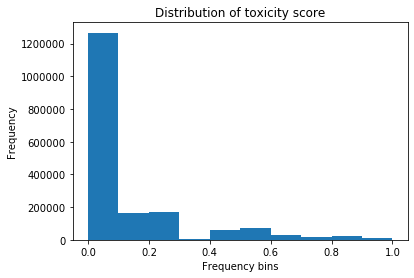

In [17]:
# Plot a histogram for the target column
plt.figure()
plt.hist(train_df['target'])
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of toxicity score')
plt.show()

We can see that by far the majority of columns have a low toxicity score. Let us also investigate what the class distribution woul

In [18]:
train_df['target_class'] = np.where(train_df['target']>=0.5, 1, 0)

In [19]:
total_rows = len(train_df['target_class'])
total_toxic = train_df[train_df['target_class'] == 1]['target_class'].count()
total_non_toxic = total_rows - total_toxic
prop_toxic = (total_toxic/total_rows)*100
prop_non_toxic = (total_non_toxic/total_rows)*100

print(f' The total number of toxic comments is {total_toxic}, which is {prop_toxic:.2f}% of the total')
print(f' The total number of non-toxic comments is {total_non_toxic}, which is {prop_non_toxic:.2f}% of the total')

 The total number of toxic comments is 144334, which is 8.00% of the total
 The total number of non-toxic comments is 1660540, which is 92.00% of the total


As we can see, there is significant class imbalance here. This is to be expected given that most comments are not toxic, but this will have to be taken into account during modelling.

### Binarizing the identity and target columns
The aim of our model is to accurately classify toxic comments while reducing the bias from over-associating certain identities with toxicity. The current identity and target columns are not binarized as they are calculated figures from averaging out the human reviewer scores. We will do this now

In [20]:
clean_df = train_df.copy()

In [21]:
identity_cols = clean_df.loc[:,'asian':'white'].columns
identity_cols = list(identity_cols)

In [22]:
# Convert taget and identity columns to 1,0
def binarize_cols(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, 1, 0)

def convert_df_to_binary(df, target_col_name):
    bin_df = df.copy()
    for col in [target_col_name] + identity_cols:
        binarize_cols(bin_df, col)
    return bin_df

clean_df = convert_df_to_binary(clean_df, 'target')

In [23]:
display(clean_df.loc[:,identity_cols].describe())
display(clean_df['target'].describe())

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,...,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
count,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,...,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00
mean,0.00,0.00,0.00,0.01,0.00,0.02,0.03,0.00,0.00,0.01,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
std,0.05,0.03,0.01,0.09,0.02,0.15,0.17,0.03,0.02,0.08,...,0.11,0.00,0.00,0.02,0.01,0.00,0.01,0.05,0.04,0.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


count   1804874.00
mean          0.08
std           0.27
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: target, dtype: float64

### Test Data:
Let's apply the same cleaning steps to the test data. For integrity we will make no changes to what we have done on the training data. Given we now have access to both the public and private test sets we will also combine the two.

We will:

1) Fill in NaN's int he identity columns with 0

2) Drop the parent_id column

3) binarize target and identity columns

In [24]:
test_df.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [25]:
len(test_df['id'])

97320

In [26]:
test_df_pub.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,nan,164149,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.00,154341,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.00,332005,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,nan,167110,approved,0,0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,nan,148484,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [27]:
len(test_df_pub['id'])

97320

In [28]:
test_df_prv.tail()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
97315,7194635,He should lose his job for promoting mis-infor...,2017-06-24 15:03:18.681506+00,54,5235573.00,333226,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
97316,7194636,"""Thinning project is meant to lower fire dange...",2017-09-22 22:23:14.612476+00,13,nan,380644,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
97317,7194637,I hope you millennials are happy that you put ...,2017-01-25 03:07:25.614392+00,54,nan,163903,rejected,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
97318,7194638,I'm thinking Kellyanne Conway (a.k.a. The Trum...,2017-01-01 03:10:29.109336+00,13,775994.00,159423,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
97319,7194639,I still can't figure why a pizza in AK cost mo...,2016-04-10 02:15:00.120798+00,21,nan,97429,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [29]:
len(test_df_prv['id'])

97320

It would appear that test_df_prv and test_df are duplicates, i.e test_df_prv is just test_df but with the added information.

In [30]:
# To check we are going to loop over the range of the series length and then evaluate the id at each i.
# If the IDs are not equal, we continue, else we append them to the list. This list should be empty if no duplicates
# and if completely duplicated the length will = the number of rows of the dfs 97320

dup_list = []
for i in range(len(test_df_prv['id'])):
    if test_df_prv['id'].loc[i] != test_df['id'].loc[i]:
        continue
    else:
        dup_list.append(test_df_prv['id'].loc[i])
        

In [31]:
print(len(dup_list))

97320


As we can see, test_df which is the test dataset with no identity labels and test_df_prv which is the private test dataset with identity labels are identical. For our purposes we will continue to process test_df_prv in line with what we have stated above. 

In [32]:
# QUick check for duplicates between test_df_prv and test_df_pub
dup_list = []
for i in range(len(test_df_prv['id'])):
    if test_df_prv['id'].loc[i] != test_df_pub['id'].loc[i]:
        continue
    else:
        dup_list.append(test_df_prv['id'].loc[i])

In [33]:
print(len(dup_list))

0


No duplicates between the public and private sets, so we are ok to combine them. 

In [34]:
#concat the two datasets
test_df_concat = pd.concat([test_df_pub,test_df_prv], axis=0)

In [35]:
test_df_concat.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,nan,164149,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.00,154341,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.00,332005,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,nan,167110,approved,0,0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,nan,148484,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [36]:
print(len(test_df_concat))

194640


We can now process this combined test set for our purposes.

#### Check for nulls

In [37]:
test_df_concat.isna().sum()

id                                          0
comment_text                                0
created_date                                0
publication_id                              0
parent_id                               86160
article_id                                  0
rating                                      0
funny                                       0
wow                                         0
sad                                         0
likes                                       0
disagree                                    0
toxicity                                    0
severe_toxicity                             0
obscene                                     0
sexual_explicit                             0
identity_attack                             0
insult                                      0
threat                                      0
identity_annotator_count                    0
toxicity_annotator_count                    0
male                              

It would appear as though a similar pattern as we have sene for the train dataset exists here. We will follow the same procedure and drop parent_ID and fill the nulls in the identity columns with 0.

In [38]:
# Drop parent id
test_df_concat.drop('parent_id', axis=1, inplace=True)


In [39]:
# fill nulls in identity columns with 0
columns = test_df_concat.loc[:,'male':'other_disability'].columns
for i in columns:
    test_df_concat[i].fillna(0, inplace=True)

In [40]:
test_df_concat.isna().sum()

id                                     0
comment_text                           0
created_date                           0
publication_id                         0
article_id                             0
rating                                 0
funny                                  0
wow                                    0
sad                                    0
likes                                  0
disagree                               0
toxicity                               0
severe_toxicity                        0
obscene                                0
sexual_explicit                        0
identity_attack                        0
insult                                 0
threat                                 0
identity_annotator_count               0
toxicity_annotator_count               0
male                                   0
female                                 0
transgender                            0
other_gender                           0
heterosexual    

In [41]:
# binarize identity and target col - we know this is the toxicity column from kaggle
test_df_concat = convert_df_to_binary(test_df_concat, 'toxicity')

In [42]:
test_df_concat.isna().sum()

id                                     0
comment_text                           0
created_date                           0
publication_id                         0
article_id                             0
rating                                 0
funny                                  0
wow                                    0
sad                                    0
likes                                  0
disagree                               0
toxicity                               0
severe_toxicity                        0
obscene                                0
sexual_explicit                        0
identity_attack                        0
insult                                 0
threat                                 0
identity_annotator_count               0
toxicity_annotator_count               0
male                                   0
female                                 0
transgender                            0
other_gender                           0
heterosexual    

### Output to csv

In [50]:
clean_df.to_csv('data/train_clean.csv')

In [51]:
test_df_concat.to_csv('data/test_clean.csv')